In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import scipy

plt.rcParams["figure.figsize"] = (16,9)

In [2]:
start_date = '2016-01-04T00'
end_date = '2020-03-02T00'

#### Import Price Data

In [3]:
price_data = pd.read_csv("../price data/iDhP/candles_btc-usd_1h.csv")
price_data['timestamp'] = [pd.Timestamp(t) for t in price_data['timestamp']]
price_data['from'] = [pd.Timestamp(t) for t in price_data['from']]
price_data['to'] = [pd.Timestamp(t) for t in price_data['to']]
price_data.head()

,timestamp,exchange,market,base,quote,from,to,open,close,high,low,volume_base,volume_quote
0,2011-01-01 00:00:00,cccagg,btc-usd,btc,usd,2010-12-31 23:00:00,2011-01-01 00:00:00,0.29200,0.29200,0.3,0.292,117.551667,35.08125
1,2011-01-01 01:00:00,cccagg,btc-usd,btc,usd,2011-01-01 00:00:00,2011-01-01 01:00:00,0.29997,0.29997,0.3,0.289,223.004583,66.02750
2,2011-01-01 02:00:00,cccagg,btc-usd,btc,usd,2011-01-01 01:00:00,2011-01-01 02:00:00,0.29997,0.29997,0.3,0.289,223.004583,66.02750
3,2011-01-01 03:00:00,cccagg,btc-usd,btc,usd,2011-01-01 02:00:00,2011-01-01 03:00:00,0.29997,0.29997,0.3,0.289,223.004583,66.02750
4,2011-01-01 04:00:00,cccagg,btc-usd,btc,usd,2011-01-01 03:00:00,2011-01-01 04:00:00,0.29997,0.29997,0.3,0.289,223.004583,66.02750


#### Import Wikipedia User Activity Data

In [4]:
wiki_data = pd.read_csv("../data connectors/wikipedia/data.csv")
wiki_data = wiki_data[wiki_data['article'] == 'Bitcoin'].copy()
wiki_data.drop(columns=wiki_data.columns.to_list()[:1],inplace=True)
wiki_data['timestamp'] = wiki_data['timestamp'].astype('str')
wiki_data['timestamp'] = [pd.Timestamp(year=int(t[:4]),month=int(t[4:6]),day=int(t[6:8]),hour=0) for t in wiki_data['timestamp'].to_list()]
wiki_data.head()

,article,timestamp,views
0,Bitcoin,2015-07-01,13137
1,Bitcoin,2015-07-02,9938
2,Bitcoin,2015-07-03,8498
3,Bitcoin,2015-07-04,9113
4,Bitcoin,2015-07-05,8908


### Plotting data

In [5]:
price_data.index = price_data['timestamp']
wiki_data.index = wiki_data['timestamp']

In [6]:
price_data = price_data[start_date:end_date].copy()
wiki_data = wiki_data[start_date:end_date].copy()

#### Aggregation of the price data to daily level

In [7]:
price_data['day'] = [ts.strftime('%Y-%m-%d') for ts in price_data['timestamp'].to_list()]
price_data = price_data.groupby(by=['day']).mean()
price_data.index = [pd.Timestamp(ts) for ts in price_data.index.to_list()]
price_data['day'] = price_data.index

### Plot - price open value & wiki page views

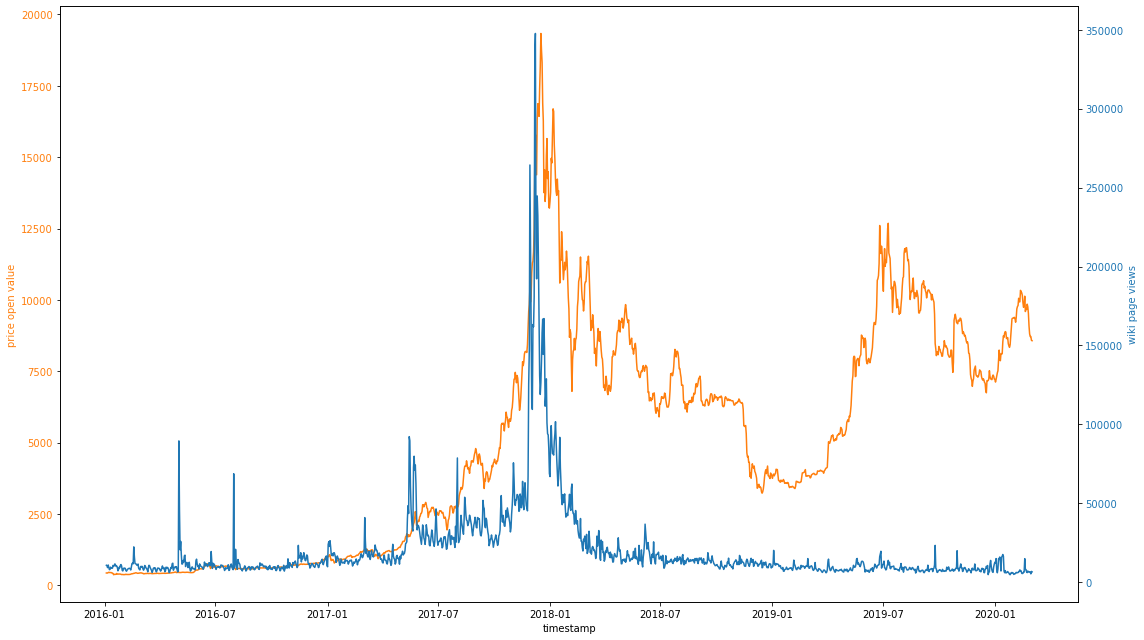

In [8]:
fig, ax1 = plt.subplots()

t = price_data['day'].values

color = 'tab:orange'
ax1.set_xlabel('timestamp')
ax1.set_ylabel('price open value', color=color)
ax1.plot(t, price_data['open'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('wiki page views', color=color)  # we already handled the x-label with ax1
ax2.plot(t, wiki_data['views'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Plot - volume base & wiki page views

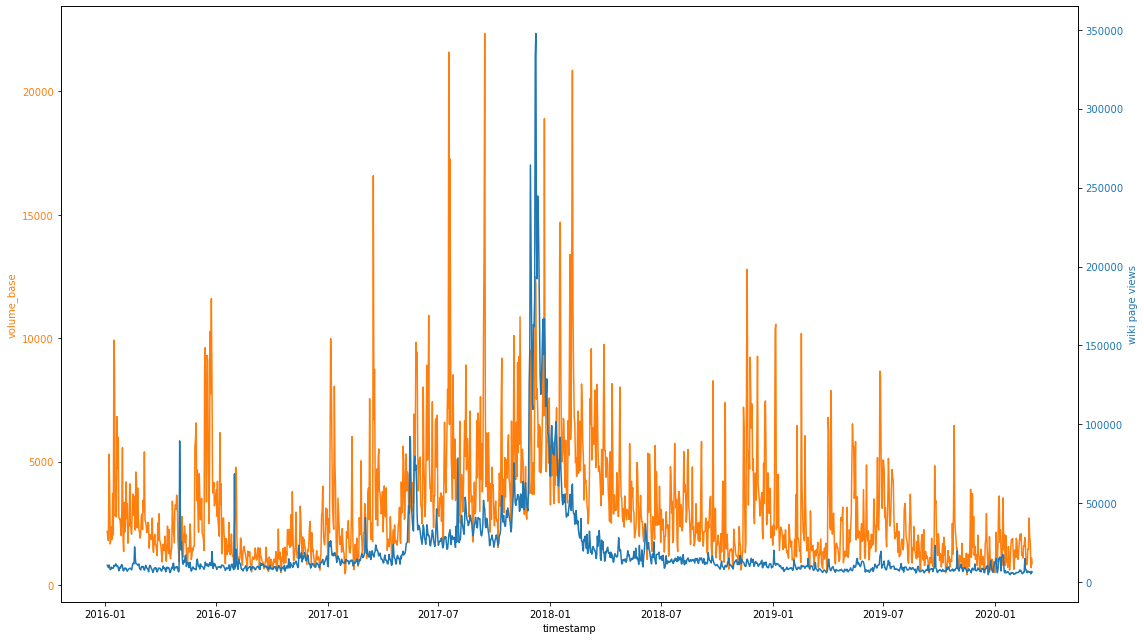

In [9]:
fig, ax1 = plt.subplots()

t = price_data['day'].values

color = 'tab:orange'
ax1.set_xlabel('timestamp')
ax1.set_ylabel('volume_base', color=color)
ax1.plot(t, price_data['volume_base'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('wiki page views', color=color)  # we already handled the x-label with ax1
ax2.plot(t, wiki_data['views'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Plot - volume quote & wiki page views

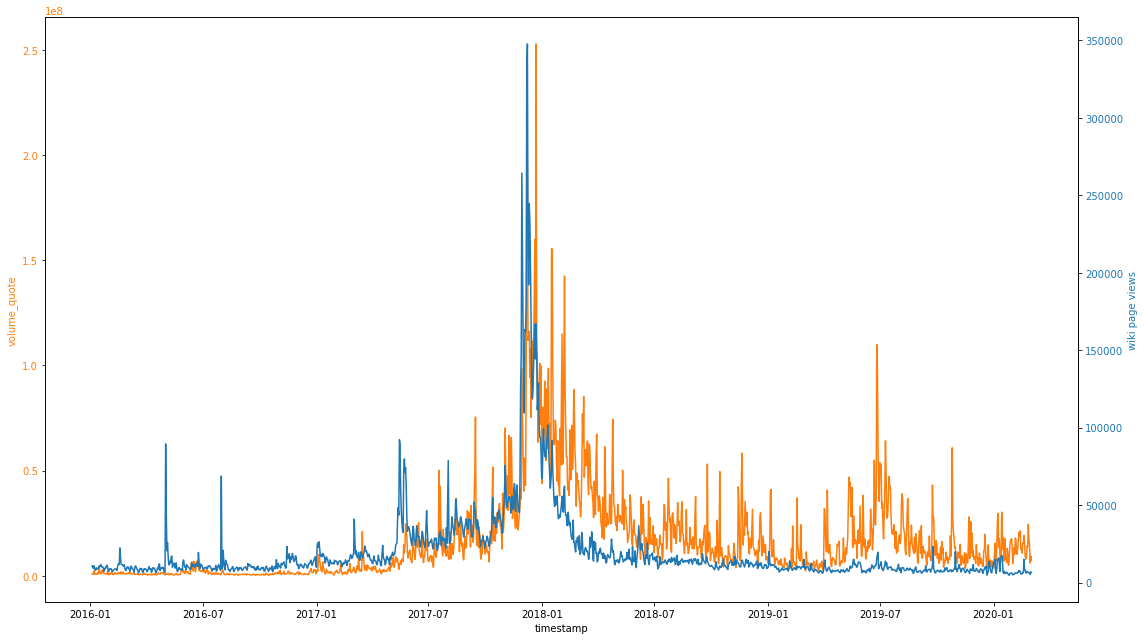

In [10]:
fig, ax1 = plt.subplots()

t = price_data['day'].values

color = 'tab:orange'
ax1.set_xlabel('timestamp')
ax1.set_ylabel('volume_quote', color=color)
ax1.plot(t, price_data['volume_quote'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('wiki page views', color=color)  # we already handled the x-label with ax1
ax2.plot(t, wiki_data['views'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Testing the Stationarity of the Time Series

source: https://machinelearningmastery.com/time-series-data-stationary-python/

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [11]:
ts = np.array(price_data['open'])
ts = ts[~np.isnan(ts)]

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.791731
p-value: 0.384575
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


In [12]:
ts = np.array(wiki_data['views'])
ts = ts[~np.isnan(ts)]

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.050031
p-value: 0.030479
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


p value of the test result of Price data is bigger than 0.05, it is non-stationary.

p value of the test result of Wiki page-views data is smaller than 0.05 but bigger than 0.01. It is better to take it as non-stationary too.

### Convert Non-Stationary Time Series to Stationary

In [13]:
ts = np.array(price_data['open'].diff())
ts = ts[~np.isnan(ts)]

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.599593
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


In [14]:
ts = np.array(wiki_data['views'].diff())
ts = ts[~np.isnan(ts)]

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.622834
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


both p values are way more smaller than 0.05 -> series are stationary (with difference operation)

### Windowed Time Lagged Cross Correlation (page_views<->price)

In [15]:
corr_start = '2018-01-01'
corr_finish = '2020-01-01'

In [16]:
price_d = price_data[corr_start:corr_finish].copy()
wiki_d = wiki_data[corr_start:corr_finish].copy()

### Log-Difference Operation

In [17]:
price_d['log_diff_open'] = np.log(price_d['open']).diff()
wiki_d['log_diff_views'] = np.log(wiki_d['views']).diff()

#price_d['log_diff_volume_base'] = np.log(price_d['volume_base']).diff()
#wiki_d['log_diff_views'] = np.log(wiki_d['views']).diff()

#price_d['log_diff_volume_quote'] = np.log(price_d['volume_quote']).diff()
#wiki_d['log_diff_views'] = np.log(wiki_d['views']).diff()

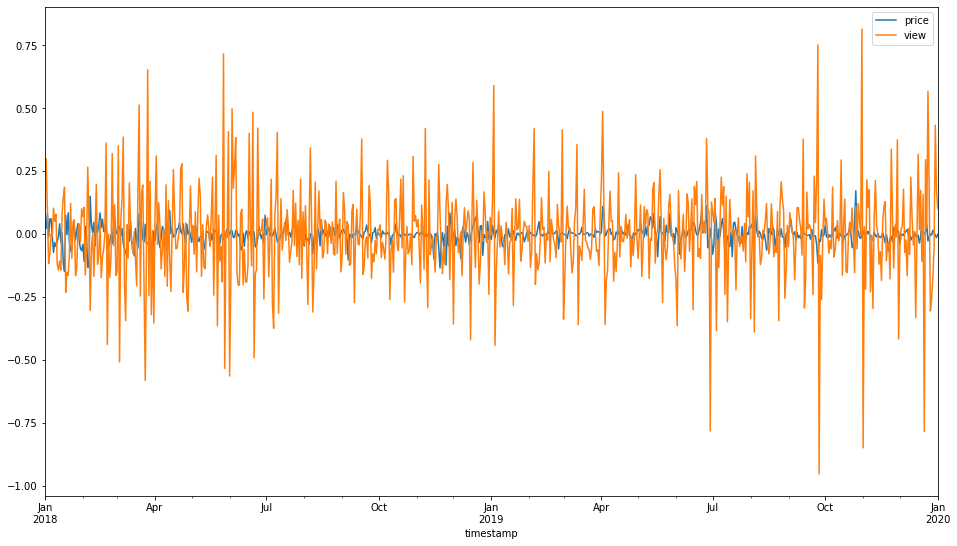

In [18]:
price_d['log_diff_open'].plot(label='price')
wiki_d['log_diff_views'].plot(label='view')

plt.legend()
plt.show()

### Pearson correlation of log-diff

In [19]:
import time

start = time.time()

data_dict = dict()

lag = 14 # days
window_size = [7,14,30] # days
i=0
for w in window_size:
    for t in range(price_d.shape[0]-lag-w):
        ts_1 = pd.Series(price_d.iloc[t+lag:t+lag+w]['log_diff_open'].values)
        
        for l in range(lag+1):
            ts_2 = pd.Series(wiki_d.iloc[t+l:t+l+w]['log_diff_views'].values)
            try:
                corr = scipy.stats.pearsonr(np.float32(ts_1.values),np.float32(ts_2.values))[0]
            except:
                corr = np.nan
            
            for w_i in range(w):
                try:
                    price_ts = price_d.iloc[t+lag+w_i:t+lag+w_i+1].index.to_list()[0]
                    wiki_ts = wiki_d.iloc[t+l+w_i:t+l+w_i+1].index.to_list()[0]
                except:
                    price_ts = price_d.iloc[t+lag+w_i:].index.to_list()[0]
                    wiki_ts = wiki_d.iloc[t+l+w_i:].index.to_list()[0]
                
                data_dict[i] = {'user_activity':'wiki_page_view',
                                'time_offset': t,
                                'timestamp_price':price_ts,
                                'timestamp_wiki':wiki_ts,
                                'price':ts_1[w_i],
                                'wiki_page_view':ts_2[w_i],
                                'window_size':w,
                                'lag':l,
                                'pearson_corr':corr}
                i += 1
    

pearson_correlation_data = pd.DataFrame.from_dict(data_dict, "index")
finish = time.time()
print('data generation took ',str(finish-start),' secs')

data generation took  306.0099472999573  secs


### Pearson correlation of normal values

In [42]:
import time

start = time.time()

data_dict = dict()

lag = 14 # days
window_size = [7,14,30] # days
i=0
for w in window_size:
    for t in range(price_d.shape[0]-lag-w):
        ts_1 = pd.Series(price_d.iloc[t+lag:t+lag+w]['open'].values)
        
        for l in range(lag+1):
            ts_2 = pd.Series(wiki_d.iloc[t+l:t+l+w]['views'].values)
            try:
                corr = scipy.stats.pearsonr(np.float32(ts_1.values),np.float32(ts_2.values))[0]
            except:
                corr = np.nan
            
            for w_i in range(w):
                try:
                    price_ts = price_d.iloc[t+lag+w_i:t+lag+w_i+1].index.to_list()[0]
                    wiki_ts = wiki_d.iloc[t+l+w_i:t+l+w_i+1].index.to_list()[0]
                except:
                    price_ts = price_d.iloc[t+lag+w_i:].index.to_list()[0]
                    wiki_ts = wiki_d.iloc[t+l+w_i:].index.to_list()[0]
                
                data_dict[i] = {'user_activity':'wiki_page_view',
                                'time_offset': t,
                                'timestamp_price':price_ts,
                                'timestamp_wiki':wiki_ts,
                                'price':ts_1[w_i],
                                'wiki_page_view':ts_2[w_i],
                                'window_size':w,
                                'lag':l,
                                'pearson_corr':corr}
                i += 1
    

pearson_correlation_data_normal = pd.DataFrame.from_dict(data_dict, "index")
finish = time.time()
print('data generation took ',str(finish-start),' secs')

data generation took  243.66790986061096  secs


In [48]:
pearson_correlation_data.dropna(inplace=True)
pearson_correlation_data_normal.dropna(inplace=True)

In [58]:
pearson_correlation_data.head()

,user_activity,time_offset,timestamp_price,timestamp_wiki,price,wiki_page_view,window_size,lag,pearson_corr
7,wiki_page_view,0,2018-01-15,2018-01-02,0.005724,0.298885,7,1,0.043627
8,wiki_page_view,0,2018-01-16,2018-01-03,-0.118691,0.094554,7,1,0.043627
9,wiki_page_view,0,2018-01-17,2018-01-04,-0.148057,-0.117491,7,1,0.043627
10,wiki_page_view,0,2018-01-18,2018-01-05,0.074587,-0.078038,7,1,0.043627
11,wiki_page_view,0,2018-01-19,2018-01-06,-0.002198,-0.000454,7,1,0.043627


In [59]:
pearson_correlation_data_normal.head()

,user_activity,time_offset,timestamp_price,timestamp_wiki,price,wiki_page_view,window_size,lag,pearson_corr
0,wiki_page_view,0,2018-01-15,2018-01-01,13827.26000,66949,7,0,-0.857017
1,wiki_page_view,0,2018-01-16,2018-01-02,12279.74500,90271,7,0,-0.857017
2,wiki_page_view,0,2018-01-17,2018-01-03,10589.83375,99223,7,0,-0.857017
3,wiki_page_view,0,2018-01-18,2018-01-04,11409.89750,88224,7,0,-0.857017
4,wiki_page_view,0,2018-01-19,2018-01-05,11384.85125,81601,7,0,-0.857017


In [49]:
pcd = pearson_correlation_data.groupby(by=['time_offset','window_size','lag'],as_index=False).mean()
pcdn = pearson_correlation_data.groupby(by=['time_offset','window_size','lag'],as_index=False).mean()

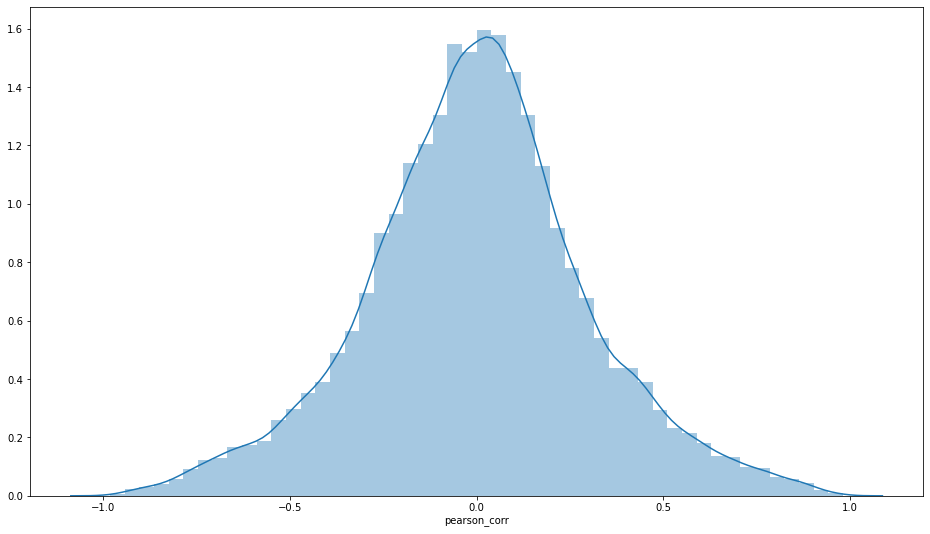

In [23]:
sns.distplot(pcd['pearson_corr'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


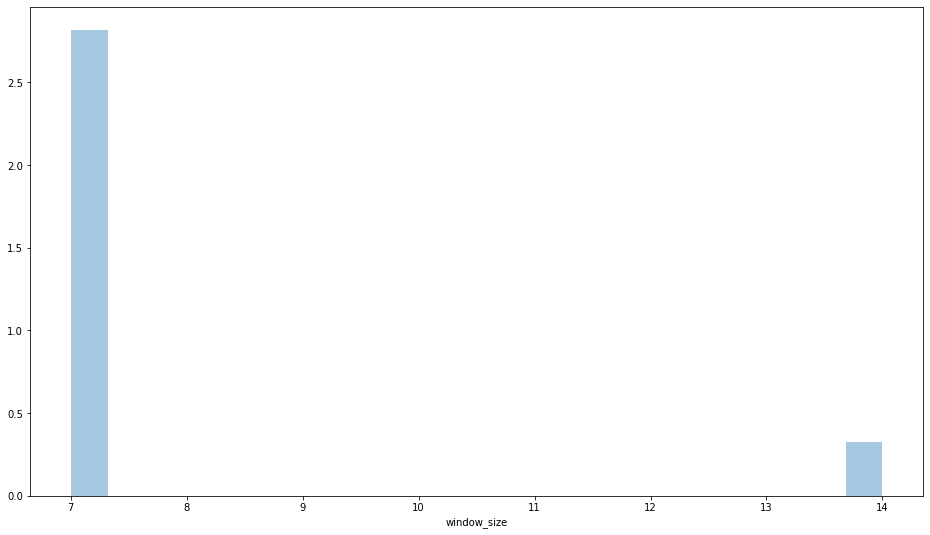

In [28]:
sns.distplot(pcd[pcd['pearson_corr'] > 0.7]['window_size'])

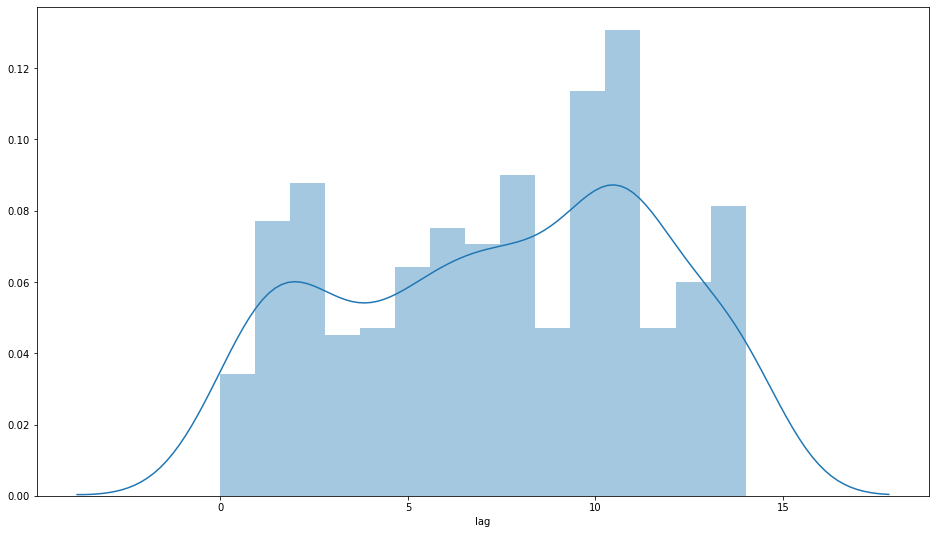

In [72]:
sns.distplot(pcd[pcd['pearson_corr'] > 0.7]['lag'],bins=15)

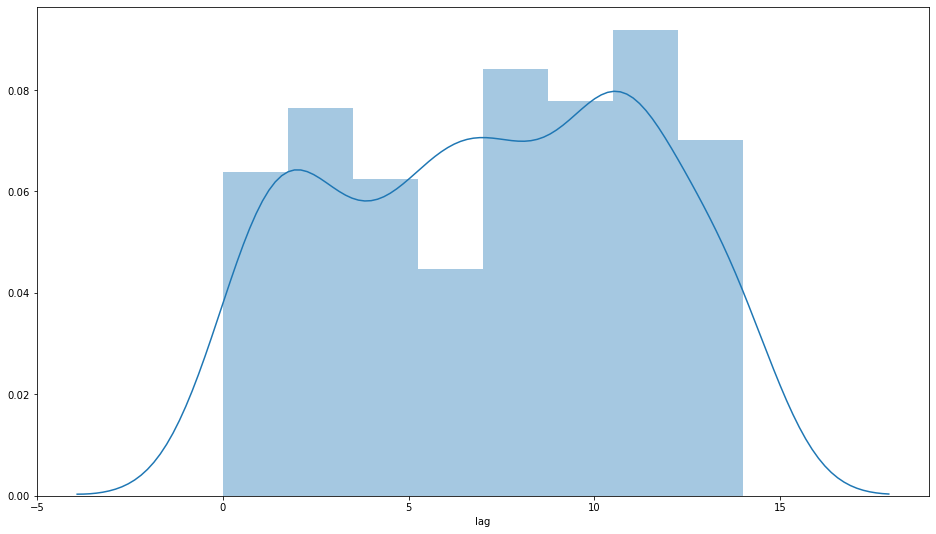

In [30]:
sns.distplot(pcd[(pcd['pearson_corr'] > 0.7) & (pcd['window_size'] == 7)]['lag'])

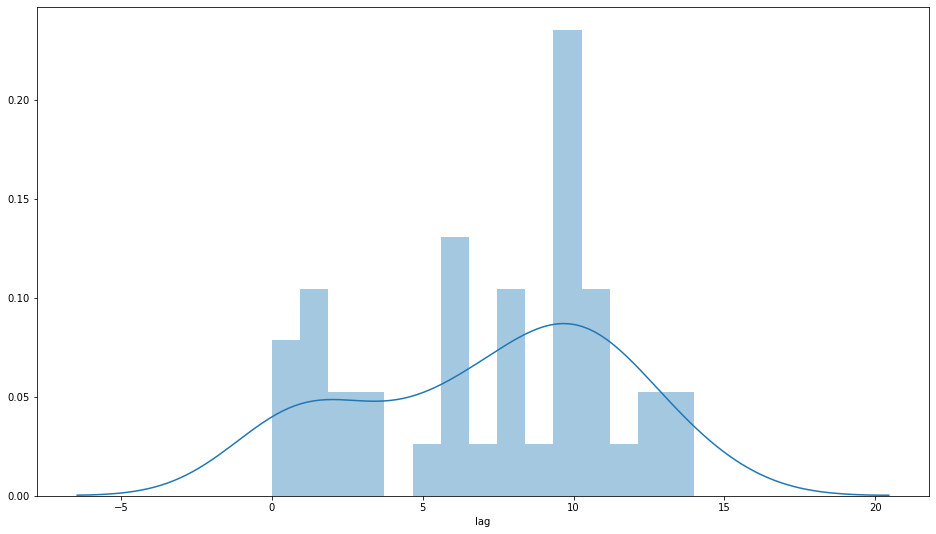

In [61]:
sns.distplot(pcd[(pcd['pearson_corr'] > 0.9) & (pcd['window_size'] == 7)]['lag'],bins=15)

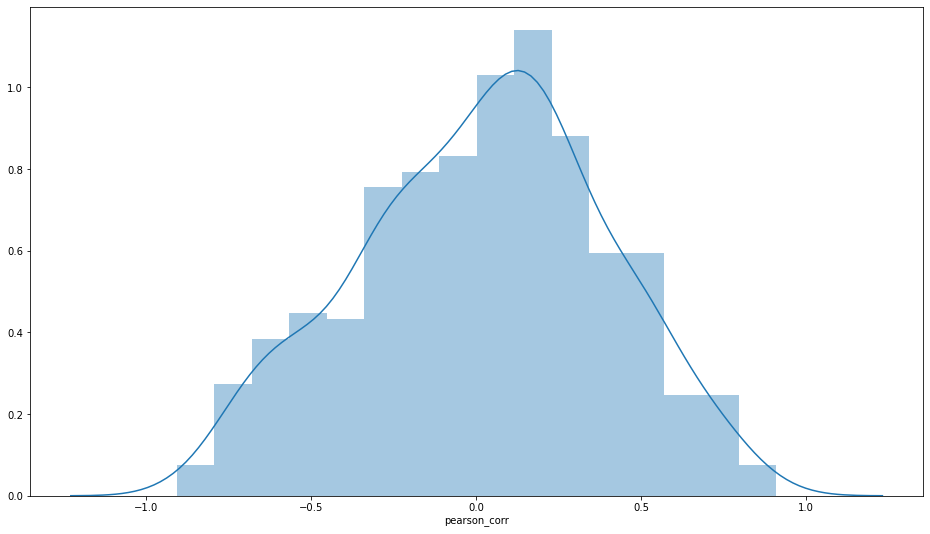

In [63]:
sns.distplot(pcd[(pcd['lag'] == 9) & (pcd['window_size'] == 7)]['pearson_corr'])

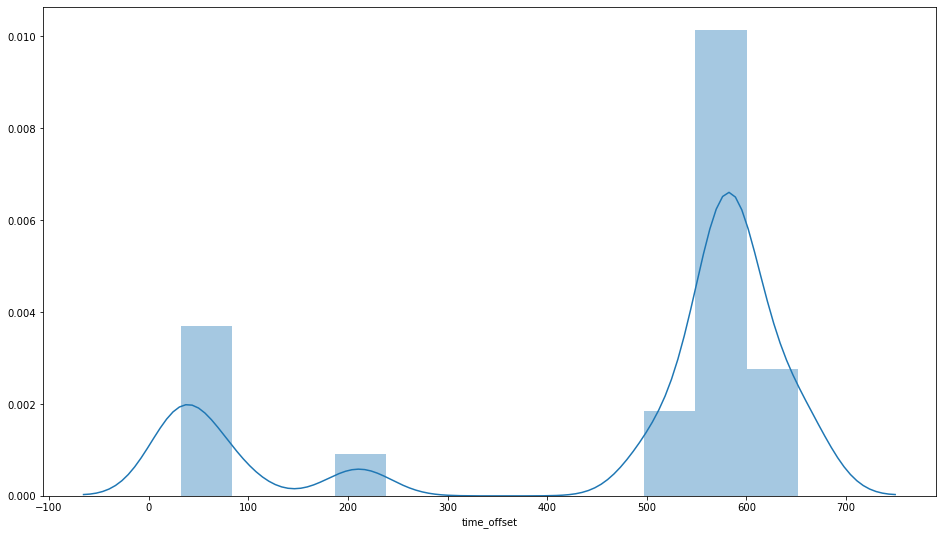

In [64]:
sns.distplot(pcd[(pcd['lag'] == 9) & 
                 (pcd['window_size'] == 7) & 
                 (pcd['pearson_corr'] > 0.7)]['time_offset'])

In [1]:
sns.distplot(pcd[(pcd['lag'] == 9) & 
                 (pcd['window_size'] == 7) & 
                 (pcd['time_offset'] > 500) &
                 (pcd['time_offset'] < 600)]['pearson_corr'],bins=20)
print(pcd[(pcd['lag'] == 9) & 
                 (pcd['window_size'] == 7) & 
                 (pcd['time_offset'] > 500) &
                 (pcd['time_offset'] < 600)].shape())

NameError: name 'sns' is not defined

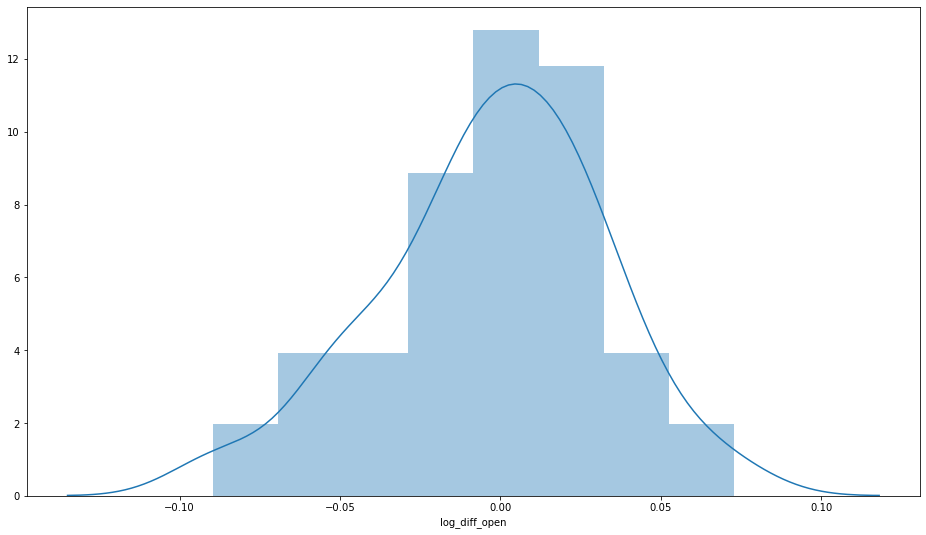

In [66]:
sns.distplot(price_d.iloc[550:600]['log_diff_open'])

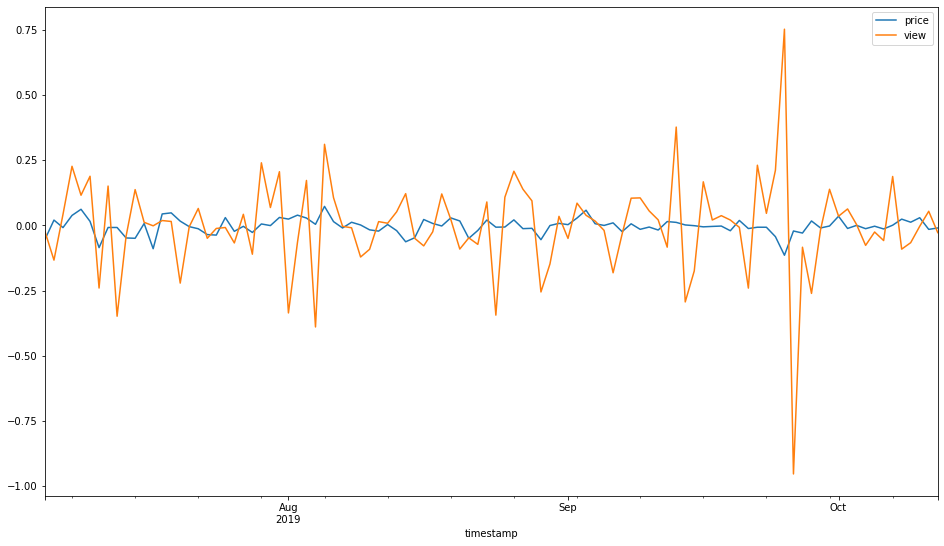

In [67]:
price_d.iloc[550:650]['log_diff_open'].plot(label='price')
wiki_d.iloc[550:650]['log_diff_views'].plot(label='view')

plt.legend()
plt.show()

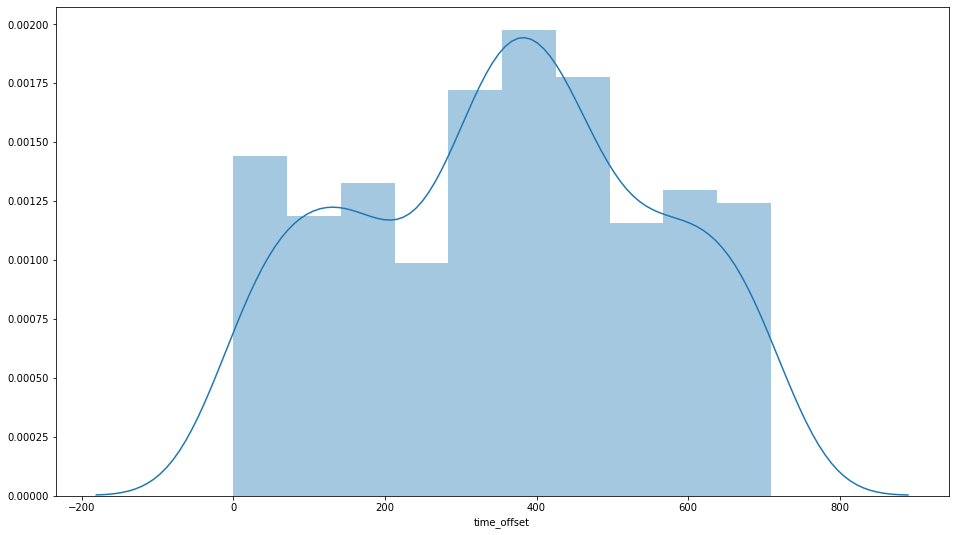

In [27]:
sns.distplot(pcd[pcd['pearson_corr'] > 0.7]['time_offset'])

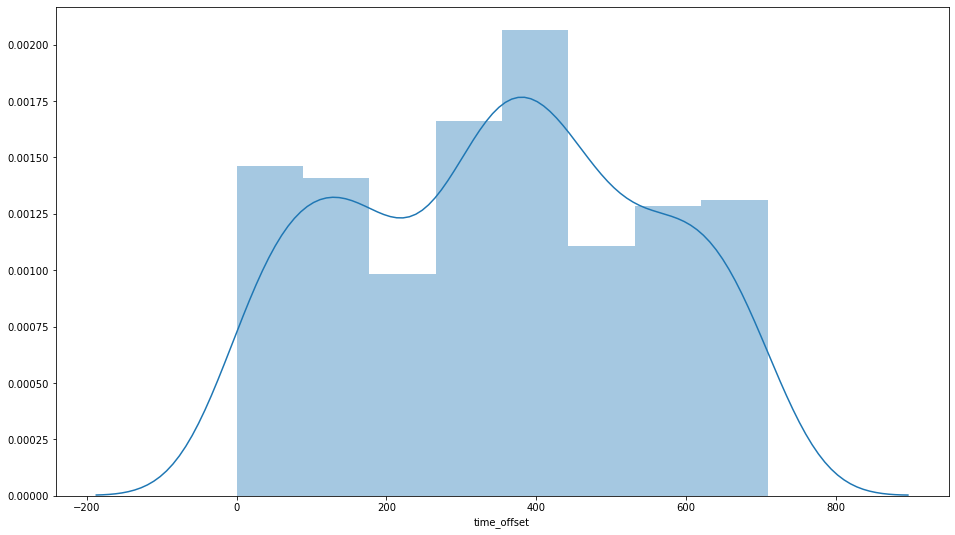

In [47]:
sns.distplot(pcd[(pcd['pearson_corr'] > 0.7) & (pcd['window_size'] == 7)]['time_offset'])

In [ ]:
sns.distplot(pcd[(pcd['pearson_corr'] > 0.7) & (pcd['window_size'] == 7)]['time_offset'])

In [39]:
price_d

,open,close,high,low,volume_base,volume_quote,day,log_diff_open
2018-01-01,13455.499167,13439.505000,13569.228750,13333.343333,3246.230000,4.381924e+07,2018-01-01,NaN
2018-01-02,13778.166667,13833.085833,13972.342917,13687.573750,5655.582500,8.012884e+07,2018-01-02,0.023697
2018-01-03,14961.023333,14961.918333,15087.780417,14853.067917,4439.561250,6.679324e+07,2018-01-03,0.082363
2018-01-04,14794.951667,14803.216667,14911.957500,14689.690417,4669.406963,6.969338e+07,2018-01-04,-0.011162
2018-01-05,15711.077917,15791.496667,15875.772500,15623.315833,5781.118750,9.255815e+07,2018-01-05,0.060080
...,...,...,...,...,...,...,...,...
2019-12-28,7314.396667,7317.531667,7333.904583,7299.270000,587.262917,4.301218e+06,2019-12-28,0.015168
2019-12-29,7366.992500,7370.555417,7389.877083,7346.496250,790.078333,5.857591e+06,2019-12-29,0.007165
2019-12-30,7325.580000,7319.829583,7342.349167,7304.872083,951.099583,6.948611e+06,2019-12-30,-0.005637
2019-12-31,7226.123333,7222.570833,7243.907500,7205.635833,803.921250,5.811638e+06,2019-12-31,-0.013670


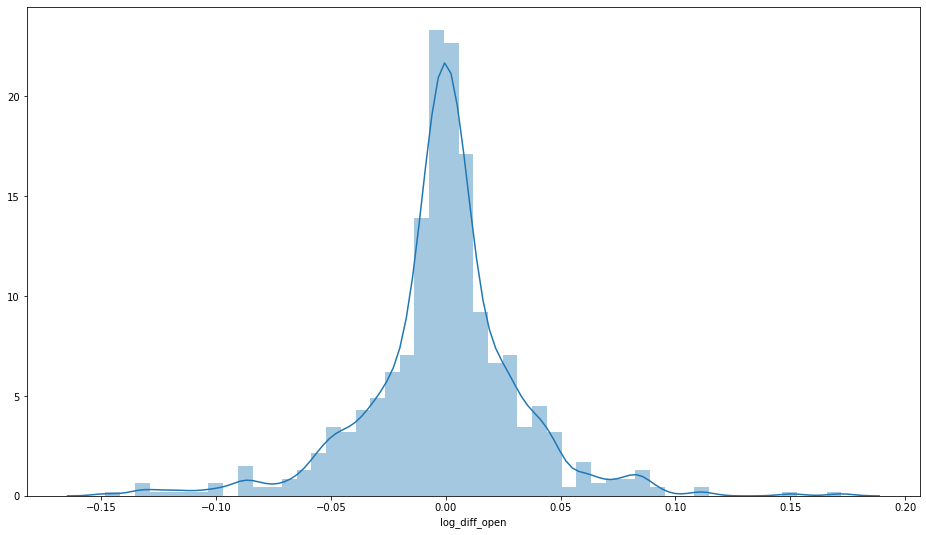

In [41]:
sns.distplot(price_d.dropna()['log_diff_open'])

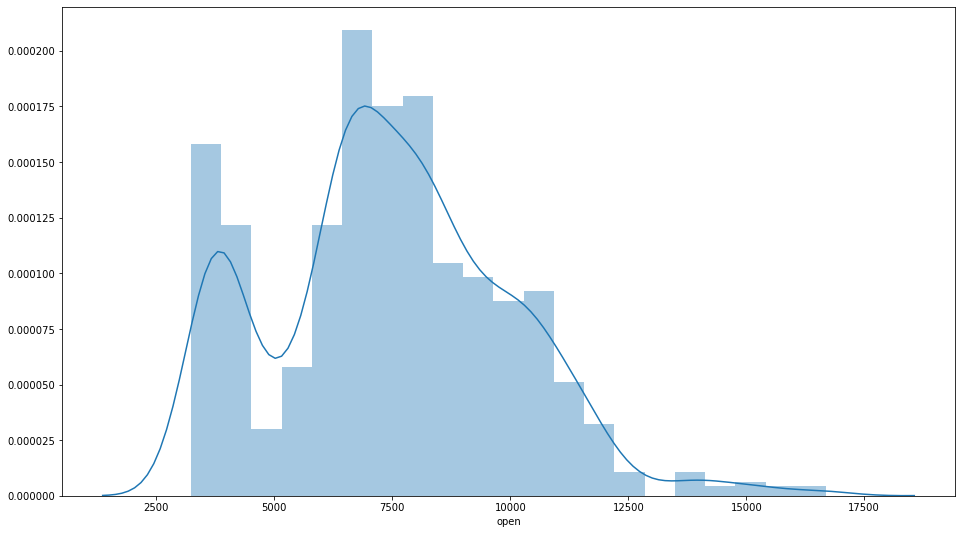

In [43]:
sns.distplot(price_d.dropna()['open'])

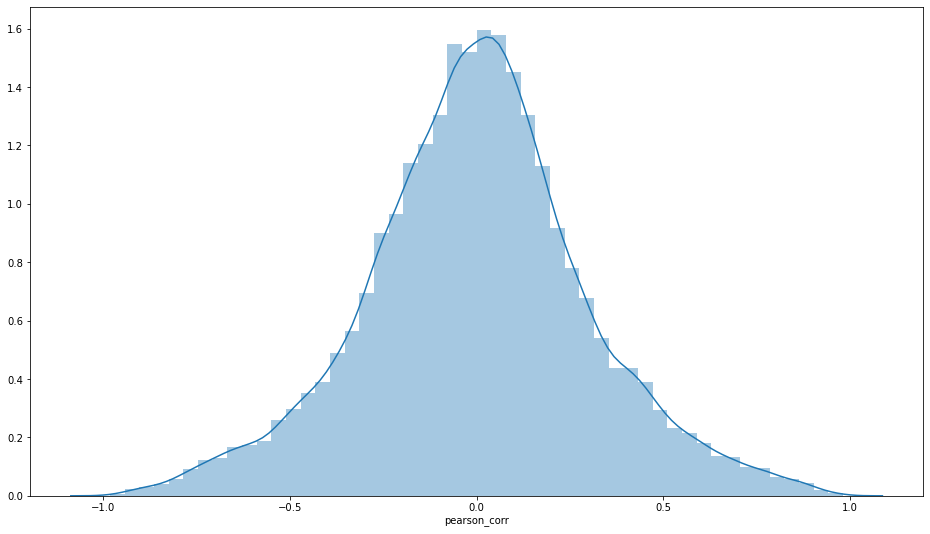

In [51]:
sns.distplot(pcdn['pearson_corr'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


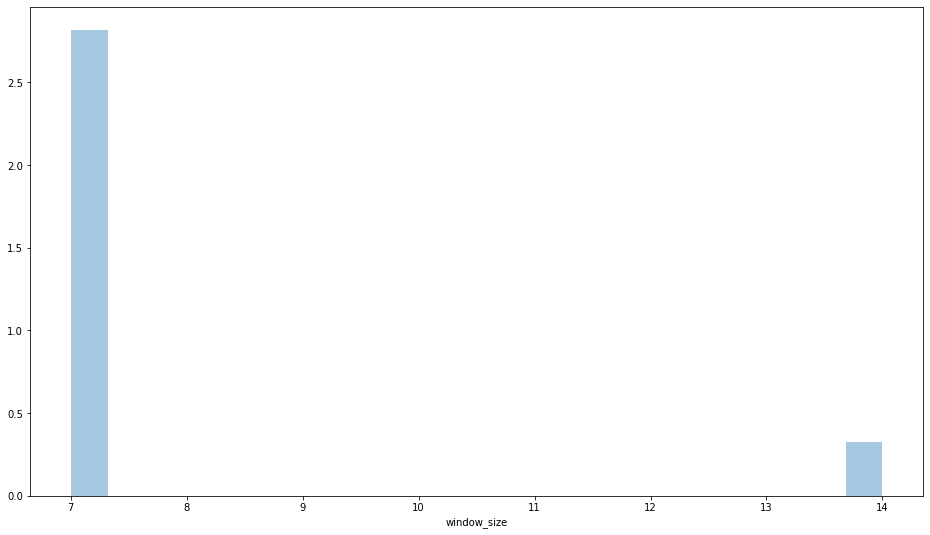

In [52]:
sns.distplot(pcdn[pcdn['pearson_corr'] > 0.7]['window_size'])

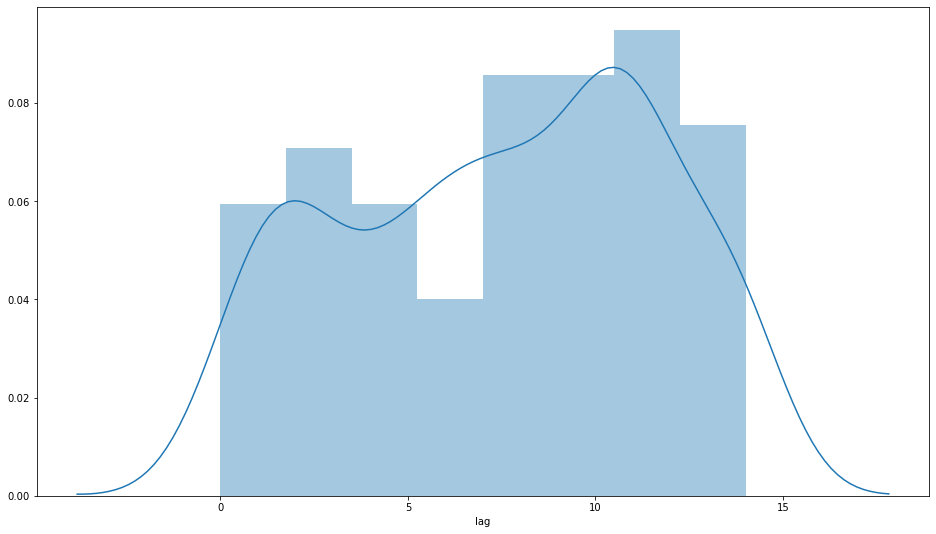

In [53]:
sns.distplot(pcdn[pcdn['pearson_corr'] > 0.7]['lag'])

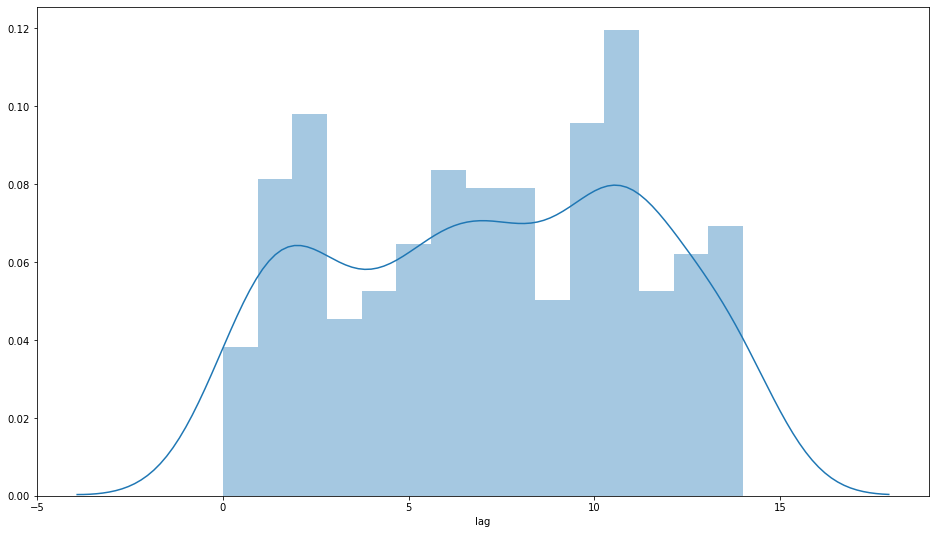

In [56]:
sns.distplot(pcdn[(pcdn['pearson_corr'] > 0.7) & (pcdn['window_size'] == 7)]['lag'],bins=15)

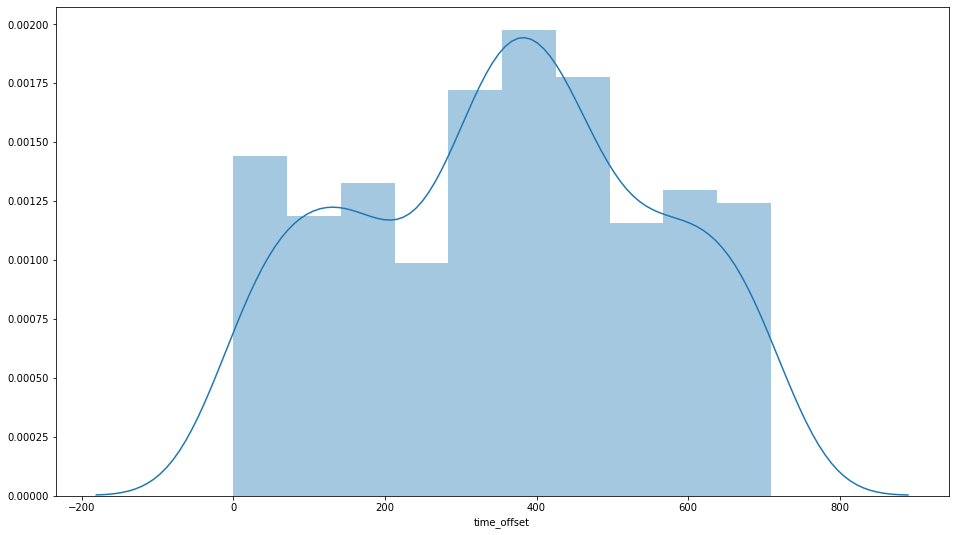

In [57]:
sns.distplot(pcdn[pcdn['pearson_corr'] > 0.7]['time_offset'])